This is the initial part of the notebook where all of the dependencies are imported.

In [4]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras import optimizers
from keras.losses import sparse_categorical_crossentropy
from keras.callbacks import ReduceLROnPlateau
import keras
from tensorboard.backend.event_processing import event_accumulator

Creating the callbacks that will be used for detecting when the model no longer improves and adjusting the learning parameter when a plateau is detected.

In [5]:
# Main example code is based on https://teksands.ai/blog/callbacks-in-keras#what-are-callbacks-in-keros

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                        min_delta=0,
                        patience=5,
                        verbose=1,
                        restore_best_weights=True)

# Main example the callback is based on https://www.kaggle.com/curiousprogrammer/lenet-5-cnn-with-keras-99-48
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', 
                                patience=3, 
                                verbose=1, 
                                factor=0.2, 
                                min_lr=1e-6)

Loading the dataset to the environment, we can download each time as it is provided by tensorflow.keras.datasets

In [6]:
# Code used from https://www.tensorflow.org/tutorials/images/cnn
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

170508288/170498071 [==============================] - 6s 0us/step


In [7]:
# Normalizing and resizing the images to avoid bias in the model
# Dataset influenced by https://towardsdatascience.com/implementing-alexnet-cnn-architecture-using-tensorflow-2-0-and-keras-2113e090ad98

def process_images_28(image, label):
    # Normalize images to have a mean of 0 and standard deviation of 1
    image = tf.image.per_image_standardization(image)
    # Resize images from 32x32 to 28x28
    image = tf.image.resize(image, (28,28))
    return image, label

Pre-processing data to avoid bias in the model. This can easily be done using from_tensor_slices as it is a dataloader that allows the procedure to be done more easily

In [8]:
# Dataset influenced by https://towardsdatascience.com/implementing-alexnet-cnn-architecture-using-tensorflow-2-0-and-keras-2113e090ad98

train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
train_ds_size = tf.data.experimental.cardinality(train_ds).numpy()
test_ds_size = tf.data.experimental.cardinality(test_ds).numpy()
print("Training data size:", train_ds_size)
print("Test data size:", test_ds_size)

Training data size: 50000
Test data size: 10000


Batch  size used is 32 and shuffle has buffere size equal to the dataset allowing randomization in the data

In [9]:
# Dataset influenced by https://towardsdatascience.com/implementing-alexnet-cnn-architecture-using-tensorflow-2-0-and-keras-2113e090ad98

train_ds_28 = (train_ds
                  .map(process_images_28)
                  .shuffle(buffer_size=train_ds_size)
                  .batch(batch_size=32, drop_remainder=True))
test_ds_28 = (test_ds
                  .map(process_images_28)
                  .shuffle(buffer_size=train_ds_size)
                  .batch(batch_size=32, drop_remainder=True))

In [10]:
# Model adapted from https://www.kaggle.com/curiousprogrammer/lenet-5-cnn-with-keras-99-48

baseline_model = Sequential()

baseline_model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(5,5), padding='same', activation='relu', input_shape=(28, 28, 3)))
baseline_model.add(tf.keras.layers.MaxPool2D(strides=2))
baseline_model.add(tf.keras.layers.BatchNormalization())
baseline_model.add(tf.keras.layers.Conv2D(filters=48, kernel_size=(5,5), padding='same', activation='relu'))
baseline_model.add(tf.keras.layers.MaxPool2D(strides=2))
baseline_model.add(tf.keras.layers.BatchNormalization())
baseline_model.add(tf.keras.layers.Flatten())
baseline_model.add(tf.keras.layers.Dropout(0.2))
baseline_model.add(tf.keras.layers.Dense(256, activation='relu'))
baseline_model.add(tf.keras.layers.Dropout(0.2))
baseline_model.add(tf.keras.layers.Dense(84, activation='relu'))
baseline_model.add(tf.keras.layers.Dropout(0.2))
baseline_model.add(tf.keras.layers.Dense(10, activation='softmax'))

In [11]:
baseline_model.compile(loss=sparse_categorical_crossentropy, optimizer=tf.optimizers.Adam(), metrics=['accuracy'])
baseline_model.summary()
model_change = baseline_model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 14, 14, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 48)        38448     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 48)         0         
 2D)                                                             
                                                        

Initial Evaluation of the baseline model using 8 epochs to analyse its performance.

In [12]:
history = baseline_model.fit(train_ds_28, epochs=8,verbose=1,
                    validation_data=(test_ds_28))

Epoch 1/8
1562/1562 [==============================] - 193s 119ms/step - loss: 1.5025 - accuracy: 0.4687 - val_loss: 1.1470 - val_accuracy: 0.5947
Epoch 2/8
1562/1562 [==============================] - 187s 118ms/step - loss: 1.1156 - accuracy: 0.6108 - val_loss: 0.9640 - val_accuracy: 0.6617
Epoch 3/8
1562/1562 [==============================] - 210s 130ms/step - loss: 0.9525 - accuracy: 0.6698 - val_loss: 0.8527 - val_accuracy: 0.7046
Epoch 4/8
1562/1562 [==============================] - 194s 122ms/step - loss: 0.8369 - accuracy: 0.7117 - val_loss: 0.8149 - val_accuracy: 0.7182
Epoch 5/8
1562/1562 [==============================] - 207s 130ms/step - loss: 0.7487 - accuracy: 0.7413 - val_loss: 0.7977 - val_accuracy: 0.7203
Epoch 6/8
1562/1562 [==============================] - 215s 136ms/step - loss: 0.6759 - accuracy: 0.7650 - val_loss: 0.7920 - val_accuracy: 0.7297
Epoch 7/8
1562/1562 [==============================] - 201s 125ms/step - loss: 0.6088 - accuracy: 0.7886 - val_loss: 0

Printing a graph of the accuracy of the model.

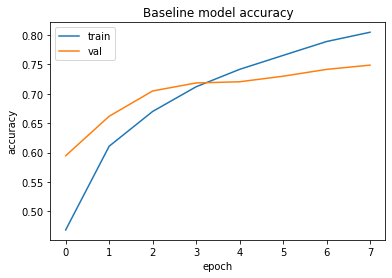

In [13]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Baseline model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Modification on the initial model to test how changing the optimiser to SGD affects the training performance.

In [ ]:
model_SGD = Sequential()

model_SGD.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(5,5), padding='same', activation='relu', input_shape=(28, 28, 3)))
model_SGD.add(tf.keras.layers.MaxPool2D(strides=2))
model_SGD.add(tf.keras.layers.BatchNormalization())
model_SGD.add(tf.keras.layers.Conv2D(filters=48, kernel_size=(5,5), padding='same', activation='relu'))
model_SGD.add(tf.keras.layers.MaxPool2D(strides=2))
model_SGD.add(tf.keras.layers.BatchNormalization())
model_SGD.add(tf.keras.layers.Flatten())
model_SGD.add(tf.keras.layers.Dropout(0.2))
model_SGD.add(tf.keras.layers.Dense(256, activation='relu'))
model_SGD.add(tf.keras.layers.Dropout(0.2))
model_SGD.add(tf.keras.layers.Dense(84, activation='relu'))
model_SGD.add(tf.keras.layers.Dropout(0.2))
model_SGD.add(tf.keras.layers.Dense(10, activation='softmax'))

model_SGD.compile(loss=sparse_categorical_crossentropy, optimizer=tf.optimizers.SGD(), metrics=['accuracy'])
model_SGD.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 28, 28, 32)        2432      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 batch_normalization_8 (Batc  (None, 14, 14, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_9 (Conv2D)           (None, 14, 14, 48)        38448     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 7, 7, 48)         0         
 2D)                                                             
                                                      

Testing the training of the SGD variant

In [ ]:
history_SGD = model_SGD.fit(train_ds_28, epochs=8,verbose=1,
                    validation_data=(test_ds_28))

Epoch 1/8
1562/1562 [==============================] - 182s 114ms/step - loss: 1.6683 - accuracy: 0.4042 - val_loss: 1.2832 - val_accuracy: 0.5429
Epoch 2/8
1562/1562 [==============================] - 186s 117ms/step - loss: 1.3110 - accuracy: 0.5293 - val_loss: 1.1193 - val_accuracy: 0.6005
Epoch 3/8
1562/1562 [==============================] - 189s 119ms/step - loss: 1.1643 - accuracy: 0.5871 - val_loss: 1.0250 - val_accuracy: 0.6364
Epoch 4/8
1562/1562 [==============================] - 195s 123ms/step - loss: 1.0521 - accuracy: 0.6288 - val_loss: 0.9510 - val_accuracy: 0.6662
Epoch 5/8
1562/1562 [==============================] - 206s 129ms/step - loss: 0.9816 - accuracy: 0.6546 - val_loss: 0.9271 - val_accuracy: 0.6746
Epoch 6/8
1562/1562 [==============================] - 186s 117ms/step - loss: 0.9233 - accuracy: 0.6757 - val_loss: 0.8735 - val_accuracy: 0.6907
Epoch 7/8
1562/1562 [==============================] - 187s 118ms/step - loss: 0.8638 - accuracy: 0.6958 - val_loss: 0

Plotting the performance of both models

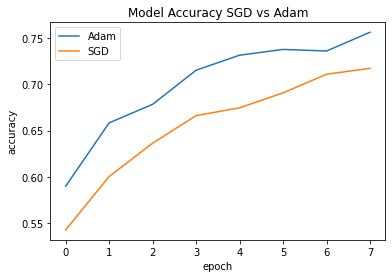

In [ ]:
plt.plot(history.history['val_accuracy'])
plt.plot(history_SGD.history['val_accuracy'])
plt.title('Model Accuracy SGD vs Adam')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Adam', 'SGD'], loc='upper left')
plt.savefig('SGDAdam')
plt.show()

Modified version of the model with input of 32x32x3. Similar to baseline architecture but the main difference if the input size in the first layer.

In [ ]:
model_v1 = Sequential()

model_v1.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(5,5), padding='same', activation='relu', input_shape=(32, 32, 3)))
model_v1.add(tf.keras.layers.MaxPool2D(strides=2))
model_v1.add(tf.keras.layers.BatchNormalization())
model_v1.add(tf.keras.layers.Conv2D(filters=48, kernel_size=(5,5), padding='same', activation='relu'))
model_v1.add(tf.keras.layers.MaxPool2D(strides=2))
model_v1.add(tf.keras.layers.BatchNormalization())
model_v1.add(tf.keras.layers.Flatten())
model_v1.add(tf.keras.layers.Dropout(0.2))
model_v1.add(tf.keras.layers.Dense(256, activation='relu'))
model_v1.add(tf.keras.layers.Dropout(0.2))
model_v1.add(tf.keras.layers.Dense(84, activation='relu'))
model_v1.add(tf.keras.layers.Dropout(0.2))
model_v1.add(tf.keras.layers.Dense(10, activation='softmax'))

In [ ]:
model_v1.compile(loss=sparse_categorical_crossentropy, optimizer=tf.optimizers.Adam(), metrics=['accuracy'])
model_v1.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 32, 32, 32)        2432      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 batch_normalization_9 (Batc  (None, 16, 16, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_10 (Conv2D)          (None, 16, 16, 48)        38448     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 8, 8, 48)         0         
 g2D)                                                            
                                                      

Testing the training the new version

In [ ]:
history_v1 = model_v1.fit(train_ds, epochs=8,verbose=1,
                    validation_data=(test_ds))

Epoch 1/8
1562/1562 [==============================] - 248s 154ms/step - loss: 1.4568 - accuracy: 0.4851 - val_loss: 1.0884 - val_accuracy: 0.6193
Epoch 2/8
1562/1562 [==============================] - 237s 150ms/step - loss: 1.0596 - accuracy: 0.6327 - val_loss: 1.0505 - val_accuracy: 0.6452
Epoch 3/8
1562/1562 [==============================] - 233s 147ms/step - loss: 0.8993 - accuracy: 0.6898 - val_loss: 0.8409 - val_accuracy: 0.7082
Epoch 4/8
1562/1562 [==============================] - 238s 150ms/step - loss: 0.7889 - accuracy: 0.7262 - val_loss: 0.7919 - val_accuracy: 0.7304
Epoch 5/8
1562/1562 [==============================] - 236s 149ms/step - loss: 0.6986 - accuracy: 0.7573 - val_loss: 0.7926 - val_accuracy: 0.7382
Epoch 6/8
1562/1562 [==============================] - 235s 148ms/step - loss: 0.6233 - accuracy: 0.7830 - val_loss: 0.7262 - val_accuracy: 0.7546
Epoch 7/8
1562/1562 [==============================] - 228s 144ms/step - loss: 0.5546 - accuracy: 0.8063 - val_loss: 0

Plotting the performance of the modified input model with the baseline model

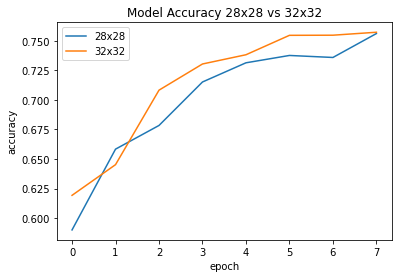

In [ ]:
plt.plot(history.history['val_accuracy'])
plt.plot(history_v1.history['val_accuracy'])
plt.title('Model Accuracy 28x28 vs 32x32')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['28x28', '32x32'], loc='upper left')
plt.savefig('DifferentInputs')
plt.show()

Plotting the accuracy of training and testing of the modified model.

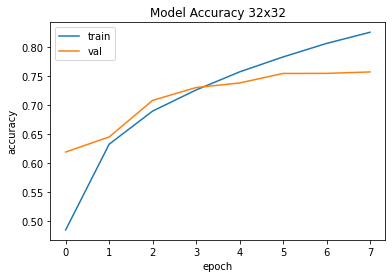

In [ ]:
plt.plot(history_v1.history['accuracy'])
plt.plot(history_v1.history['val_accuracy'])
plt.title('Model Accuracy 32x32')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Modified baseline model with different filter sizes. This is to test how they affect the performance of the model.

In [ ]:
model_dif_filter_48 = Sequential()

model_dif_filter_48.add(tf.keras.layers.Conv2D(filters=48, kernel_size=(5,5), padding='same', activation='relu', input_shape=(28, 28, 3)))
model_dif_filter_48.add(tf.keras.layers.MaxPool2D(strides=2))
model_dif_filter_48.add(tf.keras.layers.BatchNormalization())
model_dif_filter_48.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(5,5), padding='same', activation='relu'))
model_dif_filter_48.add(tf.keras.layers.MaxPool2D(strides=2))
model_dif_filter_48.add(tf.keras.layers.BatchNormalization())
model_dif_filter_48.add(tf.keras.layers.Flatten())
model_dif_filter_48.add(tf.keras.layers.Dropout(0.2))
model_dif_filter_48.add(tf.keras.layers.Dense(256, activation='relu'))
model_dif_filter_48.add(tf.keras.layers.Dropout(0.2))
model_dif_filter_48.add(tf.keras.layers.Dense(84, activation='relu'))
model_dif_filter_48.add(tf.keras.layers.Dropout(0.2))
model_dif_filter_48.add(tf.keras.layers.Dense(10, activation='softmax'))

model_dif_filter_48.compile(loss=sparse_categorical_crossentropy, optimizer=tf.optimizers.Adam(), metrics=['accuracy'])
model_dif_filter_48.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 28, 28, 48)        3648      
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 14, 14, 48)       0         
 g2D)                                                            
                                                                 
 batch_normalization_20 (Bat  (None, 14, 14, 48)       192       
 chNormalization)                                                
                                                                 
 conv2d_21 (Conv2D)          (None, 14, 14, 64)        76864     
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 7, 7, 64)         0         
 g2D)                                                            
                                                     

Training the new version of the model with the new filters and collecting the results.

In [ ]:
history_dif_filter_48 = model_dif_filter_48.fit(train_ds_28, epochs=8,verbose=1,
                    validation_data=(test_ds_28))

Epoch 1/8
1562/1562 [==============================] - 233s 145ms/step - loss: 1.5060 - accuracy: 0.4674 - val_loss: 1.1221 - val_accuracy: 0.6068
Epoch 2/8
1562/1562 [==============================] - 261s 165ms/step - loss: 1.1048 - accuracy: 0.6185 - val_loss: 0.9164 - val_accuracy: 0.6794
Epoch 3/8
1562/1562 [==============================] - 265s 168ms/step - loss: 0.9333 - accuracy: 0.6799 - val_loss: 0.8740 - val_accuracy: 0.6968
Epoch 4/8
1562/1562 [==============================] - 269s 170ms/step - loss: 0.8233 - accuracy: 0.7180 - val_loss: 0.8155 - val_accuracy: 0.7139
Epoch 5/8
1562/1562 [==============================] - 270s 170ms/step - loss: 0.7270 - accuracy: 0.7504 - val_loss: 0.7930 - val_accuracy: 0.7323
Epoch 6/8
1562/1562 [==============================] - 260s 165ms/step - loss: 0.6489 - accuracy: 0.7738 - val_loss: 0.7590 - val_accuracy: 0.7453
Epoch 7/8
1562/1562 [==============================] - 274s 173ms/step - loss: 0.5849 - accuracy: 0.7969 - val_loss: 0

Plotting the results of the testing dataset of the baseline model and of the neew filter model.

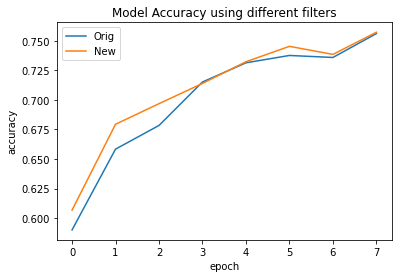

In [ ]:
plt.plot(history.history['val_accuracy'])
plt.plot(history_dif_filter_48.history['val_accuracy'])
plt.title('Model Accuracy using different filters')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Orig', 'New'], loc='upper left')
plt.savefig('DifferentFilters')
plt.show()

Plotting the training results of the different filter version of the model.

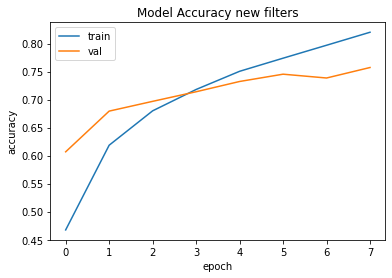

In [ ]:
plt.plot(history_dif_filter_48.history['accuracy'])
plt.plot(history_dif_filter_48.history['val_accuracy'])
plt.title('Model Accuracy new filters')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Preparing the data for the 32x32x3 input. The code is the same code as used for the input of size 28x28x3 used in the baseline model.

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

In [ ]:
# Normalizing the images to avoid bias in the model
# Dataset influenced by https://towardsdatascience.com/implementing-alexnet-cnn-architecture-using-tensorflow-2-0-and-keras-2113e090ad98

def process_images(image, label):
    # Normalize images to have a mean of 0 and standard deviation of 1
    image = tf.image.per_image_standardization(image)
    return image, label

In [ ]:
# Dataset influenced by https://towardsdatascience.com/implementing-alexnet-cnn-architecture-using-tensorflow-2-0-and-keras-2113e090ad98

train_ds_size = tf.data.experimental.cardinality(train_ds).numpy()
test_ds_size = tf.data.experimental.cardinality(test_ds).numpy()
print("Training data size:", train_ds_size)
print("Test data size:", test_ds_size)

Training data size: 50000
Test data size: 10000


In [ ]:
# Dataset influenced by https://towardsdatascience.com/implementing-alexnet-cnn-architecture-using-tensorflow-2-0-and-keras-2113e090ad98

train_ds = (train_ds
                  .map(process_images)
                  .shuffle(buffer_size=train_ds_size)
                  .batch(batch_size=32, drop_remainder=True))
test_ds = (test_ds
                  .map(process_images)
                  .shuffle(buffer_size=train_ds_size)
                  .batch(batch_size=32, drop_remainder=True))

Modifying the baseline model to accomodate the strides modification in the input model. This is to see the effect that the stride has on the output of the model.

In [ ]:
model_stride = Sequential()

model_stride.add(tf.keras.layers.Conv2D(filters=48, kernel_size=(5,5), padding='same', activation='relu', input_shape=(28, 28, 3), strides=2))
model_stride.add(tf.keras.layers.MaxPool2D(strides=2))
model_stride.add(tf.keras.layers.BatchNormalization())
model_stride.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(5,5), padding='same', activation='relu'))
model_stride.add(tf.keras.layers.MaxPool2D(strides=2))
model_stride.add(tf.keras.layers.BatchNormalization())
model_stride.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(5,5), padding='same', activation='relu'))
model_stride.add(tf.keras.layers.MaxPool2D(strides=2))
model_stride.add(tf.keras.layers.BatchNormalization())
model_stride.add(tf.keras.layers.Flatten())
model_stride.add(tf.keras.layers.Dropout(0.2))
model_stride.add(tf.keras.layers.Dense(256, activation='relu'))
model_stride.add(tf.keras.layers.Dropout(0.2))
model_stride.add(tf.keras.layers.Dense(84, activation='relu'))
model_stride.add(tf.keras.layers.Dropout(0.2))
model_stride.add(tf.keras.layers.Dense(10, activation='softmax'))

model_stride.compile(loss=sparse_categorical_crossentropy, optimizer=tf.optimizers.Adam(), metrics=['accuracy'])
model_stride.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_31 (Conv2D)          (None, 14, 14, 48)        3648      
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 7, 7, 48)         0         
 g2D)                                                            
                                                                 
 batch_normalization_31 (Bat  (None, 7, 7, 48)         192       
 chNormalization)                                                
                                                                 
 conv2d_32 (Conv2D)          (None, 7, 7, 64)          76864     
                                                                 
 max_pooling2d_32 (MaxPoolin  (None, 3, 3, 64)         0         
 g2D)                                                            
                                                     

Training the model.

In [ ]:
history_stride = model_stride.fit(train_ds_28, epochs=8,verbose=1, validation_data=test_ds_28)

Epoch 1/8
1562/1562 [==============================] - 132s 81ms/step - loss: 1.5017 - accuracy: 0.4635 - val_loss: 1.1791 - val_accuracy: 0.5757
Epoch 2/8
1562/1562 [==============================] - 124s 77ms/step - loss: 1.1537 - accuracy: 0.5973 - val_loss: 1.0094 - val_accuracy: 0.6462
Epoch 3/8
1562/1562 [==============================] - 125s 78ms/step - loss: 0.9890 - accuracy: 0.6559 - val_loss: 0.9428 - val_accuracy: 0.6717
Epoch 4/8
1562/1562 [==============================] - 125s 78ms/step - loss: 0.8793 - accuracy: 0.6983 - val_loss: 0.8992 - val_accuracy: 0.6864
Epoch 5/8
1562/1562 [==============================] - 126s 78ms/step - loss: 0.7949 - accuracy: 0.7298 - val_loss: 0.8462 - val_accuracy: 0.7103
Epoch 6/8
1562/1562 [==============================] - 125s 78ms/step - loss: 0.7276 - accuracy: 0.7503 - val_loss: 0.8514 - val_accuracy: 0.7075
Epoch 7/8
1562/1562 [==============================] - 124s 77ms/step - loss: 0.6577 - accuracy: 0.7738 - val_loss: 0.8716 -

Poltting the training and testing accuracy of the model.

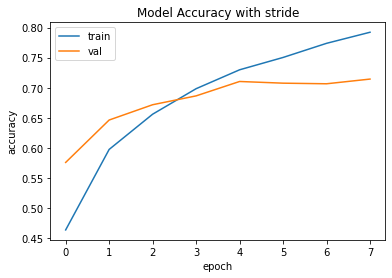

In [ ]:
plt.plot(history_stride.history['accuracy'])
plt.plot(history_stride.history['val_accuracy'])
plt.title('Model Accuracy with stride')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Plotting the difference in accuracy of the baseline model and of the model with different stride.

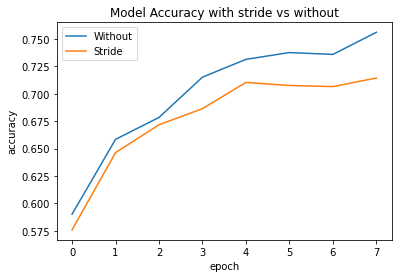

In [ ]:
plt.plot(history.history['val_accuracy'])
plt.plot(history_stride.history['val_accuracy'])
plt.title('Model Accuracy with stride vs without')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Without', 'Stride'], loc='upper left')
plt.savefig('Stride')
plt.show()

Dropout is considered an important component in creating a model that learns from robust features and is resilient in the data noise. Since the model cannot rely on other neurons and it avoids overfitting.



In [ ]:
model_no_dropout = Sequential()

model_no_dropout.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(5,5), padding='same', activation='relu', input_shape=(28, 28, 3)))
model_no_dropout.add(tf.keras.layers.MaxPool2D(strides=2))
model_no_dropout.add(tf.keras.layers.BatchNormalization())
model_no_dropout.add(tf.keras.layers.Conv2D(filters=48, kernel_size=(5,5), padding='same', activation='relu'))
model_no_dropout.add(tf.keras.layers.MaxPool2D(strides=2))
model_no_dropout.add(tf.keras.layers.BatchNormalization())
model_no_dropout.add(tf.keras.layers.Flatten())
model_no_dropout.add(tf.keras.layers.Dense(256, activation='relu'))
model_no_dropout.add(tf.keras.layers.Dense(84, activation='relu'))
model_no_dropout.add(tf.keras.layers.Dense(10, activation='softmax'))

model_no_dropout.compile(loss=sparse_categorical_crossentropy, optimizer=tf.optimizers.Adam(), metrics=['accuracy'])
model_no_dropout.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_34 (Conv2D)          (None, 28, 28, 32)        2432      
                                                                 
 max_pooling2d_34 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 batch_normalization_34 (Bat  (None, 14, 14, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_35 (Conv2D)          (None, 14, 14, 48)        38448     
                                                                 
 max_pooling2d_35 (MaxPoolin  (None, 7, 7, 48)         0         
 g2D)                                                            
                                                     

In [ ]:
history_no_dropout = model_no_dropout.fit(train_ds_28, epochs=8,verbose=1, validation_data=test_ds_28)

Epoch 1/8
1562/1562 [==============================] - 199s 123ms/step - loss: 1.2880 - accuracy: 0.5451 - val_loss: 1.0252 - val_accuracy: 0.6377
Epoch 2/8
1562/1562 [==============================] - 197s 124ms/step - loss: 0.8763 - accuracy: 0.6902 - val_loss: 0.9033 - val_accuracy: 0.6859
Epoch 3/8
1562/1562 [==============================] - 202s 126ms/step - loss: 0.6798 - accuracy: 0.7630 - val_loss: 0.8338 - val_accuracy: 0.7120
Epoch 4/8
1562/1562 [==============================] - 195s 123ms/step - loss: 0.5252 - accuracy: 0.8135 - val_loss: 0.8506 - val_accuracy: 0.7236
Epoch 5/8
1562/1562 [==============================] - 204s 129ms/step - loss: 0.3870 - accuracy: 0.8654 - val_loss: 0.9909 - val_accuracy: 0.7114
Epoch 6/8
1562/1562 [==============================] - 203s 128ms/step - loss: 0.2859 - accuracy: 0.8979 - val_loss: 1.0723 - val_accuracy: 0.7197
Epoch 7/8
1562/1562 [==============================] - 201s 127ms/step - loss: 0.2214 - accuracy: 0.9229 - val_loss: 1

Plotting the difference of using dropout and not

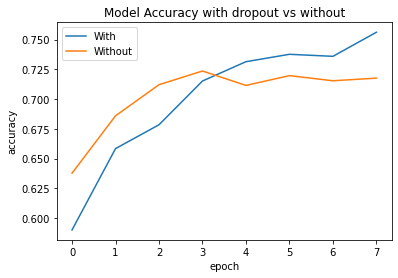

In [ ]:
plt.plot(history.history['val_accuracy'])
plt.plot(history_no_dropout.history['val_accuracy'])
plt.title('Model Accuracy with dropout vs without')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['With', 'Without'], loc='upper left')
plt.savefig('NoDropout')
plt.show()

Implementing a simple architecture to evaluate different modfications in the activation function.

The simple model used ReLu in the input layer and Softmax in the output layer.


Naming works like the following, simple_model_[activation] indicates the activation function in the convolutional layer that is being tested. All tests are conducted with the output layer having a softmax activation function.


simple_model_[activation]_end indicates the activation function used in the output layer.

In [ ]:
simple_model = Sequential()

simple_model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(5,5), padding='same', activation='relu', input_shape=(28, 28, 3)))
simple_model.add(tf.keras.layers.MaxPool2D(strides=2))
simple_model.add(tf.keras.layers.BatchNormalization())
simple_model.add(tf.keras.layers.Flatten())
simple_model.add(tf.keras.layers.Dropout(0.2))
simple_model.add(tf.keras.layers.Dense(10, activation='softmax'))

simple_model.compile(loss=sparse_categorical_crossentropy, optimizer=tf.optimizers.Adam(), metrics=['accuracy'])
simple_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 28, 28, 32)        2432      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 batch_normalization_11 (Bat  (None, 14, 14, 32)       128       
 chNormalization)                                                
                                                                 
 flatten_6 (Flatten)         (None, 6272)              0         
                                                                 
 dropout_16 (Dropout)        (None, 6272)              0         
                                                                 
 dense_16 (Dense)            (None, 10)               

In [ ]:
history_simple = simple_model.fit(train_ds_28, epochs=8,verbose=1, validation_data=test_ds_28)

Epoch 1/8
1562/1562 [==============================] - 100s 58ms/step - loss: 1.6308 - accuracy: 0.4805 - val_loss: 1.2488 - val_accuracy: 0.5681
Epoch 2/8
1562/1562 [==============================] - 84s 52ms/step - loss: 1.1667 - accuracy: 0.5960 - val_loss: 1.1286 - val_accuracy: 0.6065
Epoch 3/8
1562/1562 [==============================] - 82s 50ms/step - loss: 1.0706 - accuracy: 0.6273 - val_loss: 1.0846 - val_accuracy: 0.6240
Epoch 4/8
1562/1562 [==============================] - 81s 50ms/step - loss: 1.0202 - accuracy: 0.6471 - val_loss: 1.0737 - val_accuracy: 0.6307
Epoch 5/8
1562/1562 [==============================] - 82s 50ms/step - loss: 0.9817 - accuracy: 0.6627 - val_loss: 1.0734 - val_accuracy: 0.6292
Epoch 6/8
1562/1562 [==============================] - 82s 50ms/step - loss: 0.9524 - accuracy: 0.6695 - val_loss: 1.0515 - val_accuracy: 0.6390
Epoch 7/8
1562/1562 [==============================] - 81s 50ms/step - loss: 0.9236 - accuracy: 0.6798 - val_loss: 1.0521 - val_a

In [ ]:
simple_model_softmax = Sequential()

simple_model_softmax.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(5,5), padding='same', activation='softmax', input_shape=(28, 28, 3)))
simple_model_softmax.add(tf.keras.layers.MaxPool2D(strides=2))
simple_model_softmax.add(tf.keras.layers.BatchNormalization())
simple_model_softmax.add(tf.keras.layers.Flatten())
simple_model_softmax.add(tf.keras.layers.Dropout(0.2))
simple_model_softmax.add(tf.keras.layers.Dense(10, activation='softmax'))

simple_model_softmax.compile(loss=sparse_categorical_crossentropy, optimizer=tf.optimizers.Adam(), metrics=['accuracy'])
simple_model_softmax.summary()

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_48 (Conv2D)          (None, 28, 28, 32)        2432      
                                                                 
 max_pooling2d_48 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 batch_normalization_48 (Bat  (None, 14, 14, 32)       128       
 chNormalization)                                                
                                                                 
 flatten_28 (Flatten)        (None, 6272)              0         
                                                                 
 dropout_44 (Dropout)        (None, 6272)              0         
                                                                 
 dense_59 (Dense)            (None, 10)              

In [ ]:
history_simple_softmax = simple_model_softmax.fit(train_ds_28, epochs=8,verbose=1, validation_data=test_ds_28)

Epoch 1/8
1562/1562 [==============================] - 97s 57ms/step - loss: 1.4131 - accuracy: 0.5069 - val_loss: 1.2291 - val_accuracy: 0.5797
Epoch 2/8
1562/1562 [==============================] - 93s 58ms/step - loss: 1.1856 - accuracy: 0.5941 - val_loss: 1.2195 - val_accuracy: 0.5854
Epoch 3/8
1562/1562 [==============================] - 93s 57ms/step - loss: 1.1034 - accuracy: 0.6185 - val_loss: 1.1568 - val_accuracy: 0.6092
Epoch 4/8
1562/1562 [==============================] - 92s 57ms/step - loss: 1.0485 - accuracy: 0.6381 - val_loss: 1.1292 - val_accuracy: 0.6213
Epoch 5/8
1562/1562 [==============================] - 93s 58ms/step - loss: 1.0086 - accuracy: 0.6528 - val_loss: 1.1095 - val_accuracy: 0.6227
Epoch 6/8
1562/1562 [==============================] - 92s 57ms/step - loss: 0.9728 - accuracy: 0.6618 - val_loss: 1.0964 - val_accuracy: 0.6289
Epoch 7/8
1562/1562 [==============================] - 92s 57ms/step - loss: 0.9474 - accuracy: 0.6722 - val_loss: 1.1138 - val_ac

In [ ]:
simple_model_relu = Sequential()

simple_model_relu.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(5,5), padding='same', activation='relu', input_shape=(28, 28, 3)))
simple_model_relu.add(tf.keras.layers.MaxPool2D(strides=2))
simple_model_relu.add(tf.keras.layers.BatchNormalization())
simple_model_relu.add(tf.keras.layers.Flatten())
simple_model_relu.add(tf.keras.layers.Dropout(0.2))
simple_model_relu.add(tf.keras.layers.Dense(10, activation='softmax'))

simple_model_relu.compile(loss=sparse_categorical_crossentropy, optimizer=tf.optimizers.Adam(), metrics=['accuracy'])
simple_model_relu.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_38 (Conv2D)          (None, 28, 28, 32)        2432      
                                                                 
 max_pooling2d_38 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 batch_normalization_38 (Bat  (None, 14, 14, 32)       128       
 chNormalization)                                                
                                                                 
 flatten_18 (Flatten)        (None, 6272)              0         
                                                                 
 dropout_34 (Dropout)        (None, 6272)              0         
                                                                 
 dense_49 (Dense)            (None, 10)              

In [ ]:
history_relu = simple_model_relu.fit(train_ds_28, epochs=8,verbose=1, validation_data=test_ds_28)

Epoch 1/8
1562/1562 [==============================] - 113s 70ms/step - loss: 1.6073 - accuracy: 0.4886 - val_loss: 1.2022 - val_accuracy: 0.5891
Epoch 2/8
1562/1562 [==============================] - 99s 61ms/step - loss: 1.1352 - accuracy: 0.6095 - val_loss: 1.1232 - val_accuracy: 0.6149
Epoch 3/8
1562/1562 [==============================] - 105s 65ms/step - loss: 1.0543 - accuracy: 0.6314 - val_loss: 1.0737 - val_accuracy: 0.6309
Epoch 4/8
1562/1562 [==============================] - 114s 71ms/step - loss: 1.0098 - accuracy: 0.6513 - val_loss: 1.0751 - val_accuracy: 0.6323
Epoch 5/8
1562/1562 [==============================] - 115s 72ms/step - loss: 0.9796 - accuracy: 0.6622 - val_loss: 1.0551 - val_accuracy: 0.6344
Epoch 6/8
1562/1562 [==============================] - 115s 72ms/step - loss: 0.9518 - accuracy: 0.6710 - val_loss: 1.0317 - val_accuracy: 0.6418
Epoch 7/8
1562/1562 [==============================] - 111s 69ms/step - loss: 0.9265 - accuracy: 0.6789 - val_loss: 1.0579 - 

In [ ]:
simple_model_sigmoid = Sequential()

simple_model_sigmoid.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(5,5), padding='same', activation='sigmoid', input_shape=(28, 28, 3)))
simple_model_sigmoid.add(tf.keras.layers.MaxPool2D(strides=2))
simple_model_sigmoid.add(tf.keras.layers.BatchNormalization())
simple_model_sigmoid.add(tf.keras.layers.Flatten())
simple_model_sigmoid.add(tf.keras.layers.Dropout(0.2))
simple_model_sigmoid.add(tf.keras.layers.Dense(10, activation='softmax'))

simple_model_sigmoid.compile(loss=sparse_categorical_crossentropy, optimizer=tf.optimizers.Adam(), metrics=['accuracy'])
simple_model_sigmoid.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_39 (Conv2D)          (None, 28, 28, 32)        2432      
                                                                 
 max_pooling2d_39 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 batch_normalization_39 (Bat  (None, 14, 14, 32)       128       
 chNormalization)                                                
                                                                 
 flatten_19 (Flatten)        (None, 6272)              0         
                                                                 
 dropout_35 (Dropout)        (None, 6272)              0         
                                                                 
 dense_50 (Dense)            (None, 10)              

In [ ]:
history_sigmoid = simple_model_sigmoid.fit(train_ds_28, epochs=8,verbose=1, validation_data=test_ds_28)

Epoch 1/8
1562/1562 [==============================] - 127s 78ms/step - loss: 1.6794 - accuracy: 0.4537 - val_loss: 1.3437 - val_accuracy: 0.5402
Epoch 2/8
1562/1562 [==============================] - 125s 78ms/step - loss: 1.2512 - accuracy: 0.5674 - val_loss: 1.1994 - val_accuracy: 0.5847
Epoch 3/8
1562/1562 [==============================] - 125s 78ms/step - loss: 1.1540 - accuracy: 0.6002 - val_loss: 1.1810 - val_accuracy: 0.5884
Epoch 4/8
1562/1562 [==============================] - 116s 72ms/step - loss: 1.0937 - accuracy: 0.6208 - val_loss: 1.1168 - val_accuracy: 0.6107
Epoch 5/8
1562/1562 [==============================] - 119s 74ms/step - loss: 1.0492 - accuracy: 0.6369 - val_loss: 1.1021 - val_accuracy: 0.6182
Epoch 6/8
1562/1562 [==============================] - 119s 74ms/step - loss: 1.0182 - accuracy: 0.6454 - val_loss: 1.0710 - val_accuracy: 0.6300
Epoch 7/8
1562/1562 [==============================] - 128s 79ms/step - loss: 0.9874 - accuracy: 0.6553 - val_loss: 1.0750 -

In [ ]:
simple_model_tanh = Sequential()

simple_model_tanh.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(5,5), padding='same', activation='tanh', input_shape=(28, 28, 3)))
simple_model_tanh.add(tf.keras.layers.MaxPool2D(strides=2))
simple_model_tanh.add(tf.keras.layers.BatchNormalization())
simple_model_tanh.add(tf.keras.layers.Flatten())
simple_model_tanh.add(tf.keras.layers.Dropout(0.2))
simple_model_tanh.add(tf.keras.layers.Dense(10, activation='softmax'))

simple_model_tanh.compile(loss=sparse_categorical_crossentropy, optimizer=tf.optimizers.Adam(), metrics=['accuracy'])
simple_model_tanh.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_44 (Conv2D)          (None, 28, 28, 32)        2432      
                                                                 
 max_pooling2d_44 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 batch_normalization_44 (Bat  (None, 14, 14, 32)       128       
 chNormalization)                                                
                                                                 
 flatten_24 (Flatten)        (None, 6272)              0         
                                                                 
 dropout_40 (Dropout)        (None, 6272)              0         
                                                                 
 dense_55 (Dense)            (None, 10)              

In [ ]:
history_tanh = simple_model_tanh.fit(train_ds_28, epochs=8,verbose=1, validation_data=test_ds_28)

Epoch 1/8
1562/1562 [==============================] - 124s 76ms/step - loss: 1.7406 - accuracy: 0.4478 - val_loss: 1.2493 - val_accuracy: 0.5616
Epoch 2/8
1562/1562 [==============================] - 109s 67ms/step - loss: 1.2072 - accuracy: 0.5787 - val_loss: 1.1400 - val_accuracy: 0.6029
Epoch 3/8
1562/1562 [==============================] - 113s 70ms/step - loss: 1.1078 - accuracy: 0.6139 - val_loss: 1.0967 - val_accuracy: 0.6204
Epoch 4/8
1562/1562 [==============================] - 108s 67ms/step - loss: 1.0478 - accuracy: 0.6337 - val_loss: 1.0847 - val_accuracy: 0.6232
Epoch 5/8
1562/1562 [==============================] - 106s 66ms/step - loss: 1.0080 - accuracy: 0.6475 - val_loss: 1.0744 - val_accuracy: 0.6274
Epoch 6/8
1562/1562 [==============================] - 106s 66ms/step - loss: 0.9700 - accuracy: 0.6627 - val_loss: 1.0192 - val_accuracy: 0.6466
Epoch 7/8
1562/1562 [==============================] - 104s 64ms/step - loss: 0.9396 - accuracy: 0.6725 - val_loss: 1.0181 -

In [ ]:
simple_model_sigmoid_end = Sequential()

simple_model_sigmoid_end.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(5,5), padding='same', activation='relu', input_shape=(28, 28, 3)))
simple_model_sigmoid_end.add(tf.keras.layers.MaxPool2D(strides=2))
simple_model_sigmoid_end.add(tf.keras.layers.BatchNormalization())
simple_model_sigmoid_end.add(tf.keras.layers.Flatten())
simple_model_sigmoid_end.add(tf.keras.layers.Dropout(0.2))
simple_model_sigmoid_end.add(tf.keras.layers.Dense(10, activation='sigmoid'))

simple_model_sigmoid_end.compile(loss=sparse_categorical_crossentropy, optimizer=tf.optimizers.Adam(), metrics=['accuracy'])
simple_model_sigmoid_end.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_41 (Conv2D)          (None, 28, 28, 32)        2432      
                                                                 
 max_pooling2d_41 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 batch_normalization_41 (Bat  (None, 14, 14, 32)       128       
 chNormalization)                                                
                                                                 
 flatten_21 (Flatten)        (None, 6272)              0         
                                                                 
 dropout_37 (Dropout)        (None, 6272)              0         
                                                                 
 dense_52 (Dense)            (None, 10)              

In [ ]:
history_sigmoid_end = simple_model_sigmoid_end.fit(train_ds_28, epochs=8,verbose=1, validation_data=test_ds_28)

Epoch 1/8
1562/1562 [==============================] - 99s 61ms/step - loss: 1.6199 - accuracy: 0.4846 - val_loss: 1.2367 - val_accuracy: 0.5710
Epoch 2/8
1562/1562 [==============================] - 90s 55ms/step - loss: 1.1482 - accuracy: 0.6041 - val_loss: 1.1442 - val_accuracy: 0.6032
Epoch 3/8
1562/1562 [==============================] - 97s 60ms/step - loss: 1.0545 - accuracy: 0.6339 - val_loss: 1.1023 - val_accuracy: 0.6237
Epoch 4/8
1562/1562 [==============================] - 96s 59ms/step - loss: 1.0121 - accuracy: 0.6481 - val_loss: 1.0663 - val_accuracy: 0.6311
Epoch 5/8
1562/1562 [==============================] - 97s 60ms/step - loss: 0.9727 - accuracy: 0.6637 - val_loss: 1.0734 - val_accuracy: 0.6320
Epoch 6/8
1562/1562 [==============================] - 97s 60ms/step - loss: 0.9455 - accuracy: 0.6732 - val_loss: 1.0186 - val_accuracy: 0.6495
Epoch 7/8
1562/1562 [==============================] - 95s 59ms/step - loss: 0.9205 - accuracy: 0.6786 - val_loss: 1.0386 - val_ac

In [ ]:
simple_model_tanh_end = Sequential()

simple_model_tanh_end.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(5,5), padding='same', activation='relu', input_shape=(28, 28, 3)))
simple_model_tanh_end.add(tf.keras.layers.MaxPool2D(strides=2))
simple_model_tanh_end.add(tf.keras.layers.BatchNormalization())
simple_model_tanh_end.add(tf.keras.layers.Flatten())
simple_model_tanh_end.add(tf.keras.layers.Dropout(0.2))
simple_model_tanh_end.add(tf.keras.layers.Dense(10, activation='tanh'))

simple_model_tanh_end.compile(loss=sparse_categorical_crossentropy, optimizer=tf.optimizers.Adam(), metrics=['accuracy'])
simple_model_tanh_end.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_42 (Conv2D)          (None, 28, 28, 32)        2432      
                                                                 
 max_pooling2d_42 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 batch_normalization_42 (Bat  (None, 14, 14, 32)       128       
 chNormalization)                                                
                                                                 
 flatten_22 (Flatten)        (None, 6272)              0         
                                                                 
 dropout_38 (Dropout)        (None, 6272)              0         
                                                                 
 dense_53 (Dense)            (None, 10)              

In [ ]:
history_tanh_end = simple_model_tanh_end.fit(train_ds_28, epochs=8,verbose=1, validation_data=test_ds_28)

Epoch 1/8
1562/1562 [==============================] - 102s 62ms/step - loss: 4.2072 - accuracy: 0.1441 - val_loss: 3.5547 - val_accuracy: 0.1413
Epoch 2/8
1562/1562 [==============================] - 104s 64ms/step - loss: 3.8400 - accuracy: 0.1229 - val_loss: 4.0968 - val_accuracy: 0.1201
Epoch 3/8
1562/1562 [==============================] - 105s 65ms/step - loss: 3.5346 - accuracy: 0.1266 - val_loss: 3.4095 - val_accuracy: 0.1307
Epoch 4/8
1562/1562 [==============================] - 99s 61ms/step - loss: 3.5241 - accuracy: 0.1302 - val_loss: 3.5330 - val_accuracy: 0.1333
Epoch 5/8
1562/1562 [==============================] - 98s 61ms/step - loss: 3.2869 - accuracy: 0.1318 - val_loss: 3.1193 - val_accuracy: 0.1187
Epoch 6/8
1562/1562 [==============================] - 98s 61ms/step - loss: 3.3019 - accuracy: 0.1227 - val_loss: 3.2558 - val_accuracy: 0.1262
Epoch 7/8
1562/1562 [==============================] - 99s 61ms/step - loss: 3.1542 - accuracy: 0.1233 - val_loss: 3.2194 - val

In [ ]:
simple_model_relu_end = Sequential()

simple_model_relu_end.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(5,5), padding='same', activation='relu', input_shape=(28, 28, 3)))
simple_model_relu_end.add(tf.keras.layers.MaxPool2D(strides=2))
simple_model_relu_end.add(tf.keras.layers.BatchNormalization())
simple_model_relu_end.add(tf.keras.layers.Flatten())
simple_model_relu_end.add(tf.keras.layers.Dropout(0.2))
simple_model_relu_end.add(tf.keras.layers.Dense(10, activation='relu'))

simple_model_relu_end.compile(loss=sparse_categorical_crossentropy, optimizer=tf.optimizers.Adam(), metrics=['accuracy'])
simple_model_relu_end.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_43 (Conv2D)          (None, 28, 28, 32)        2432      
                                                                 
 max_pooling2d_43 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 batch_normalization_43 (Bat  (None, 14, 14, 32)       128       
 chNormalization)                                                
                                                                 
 flatten_23 (Flatten)        (None, 6272)              0         
                                                                 
 dropout_39 (Dropout)        (None, 6272)              0         
                                                                 
 dense_54 (Dense)            (None, 10)              

In [ ]:
history_reku_end = simple_model_relu_end.fit(train_ds_28, epochs=8,verbose=1, validation_data=test_ds_28)

Epoch 1/8
1562/1562 [==============================] - 91s 56ms/step - loss: 4.9571 - accuracy: 0.1630 - val_loss: 4.3424 - val_accuracy: 0.1592
Epoch 2/8
1562/1562 [==============================] - 105s 65ms/step - loss: 4.2008 - accuracy: 0.1257 - val_loss: 3.8680 - val_accuracy: 0.1136
Epoch 3/8
1562/1562 [==============================] - 105s 65ms/step - loss: 3.6100 - accuracy: 0.1122 - val_loss: 3.3112 - val_accuracy: 0.1078
Epoch 4/8
1562/1562 [==============================] - 94s 58ms/step - loss: 3.0162 - accuracy: 0.1132 - val_loss: 2.8322 - val_accuracy: 0.1110
Epoch 5/8
1562/1562 [==============================] - 94s 58ms/step - loss: 3.1178 - accuracy: 0.1111 - val_loss: 3.0510 - val_accuracy: 0.0976
Epoch 6/8
1562/1562 [==============================] - 103s 64ms/step - loss: 2.9512 - accuracy: 0.1081 - val_loss: 2.7538 - val_accuracy: 0.1059
Epoch 7/8
1562/1562 [==============================] - 103s 64ms/step - loss: 2.6864 - accuracy: 0.0966 - val_loss: 2.5649 - va

Plotting the Model accuracy of different activation function in the convolutional layer.

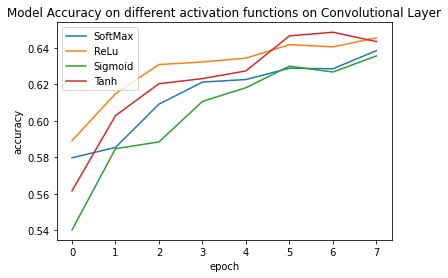

In [ ]:
plt.plot(history_simple_softmax.history['val_accuracy'])
plt.plot(history_relu.history['val_accuracy'])
plt.plot(history_sigmoid.history['val_accuracy'])
plt.plot(history_tanh.history['val_accuracy'])
plt.title('Model Accuracy of different activation functions on Convolutional Layer')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['SoftMax','ReLu', 'Sigmoid', 'Tanh'], loc='upper left')
plt.savefig('ActivationConv')
plt.show()

Plotting the Model accuracy of different activation function in the output layer.

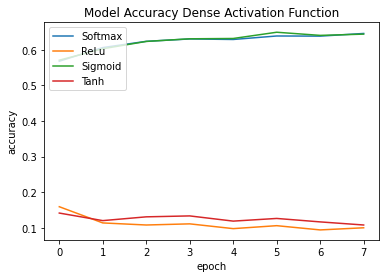

In [ ]:
plt.plot(history_simple.history['val_accuracy'])
plt.plot(history_reku_end.history['val_accuracy'])
plt.plot(history_sigmoid_end.history['val_accuracy'])
plt.plot(history_tanh_end.history['val_accuracy'])
plt.title('Model Accuracy Dense Activation Function')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Softmax','ReLu', 'Sigmoid', 'Tanh'], loc='upper left')
plt.savefig('ActivationDense')
plt.show()

In this stage we conduct the final evaluation of all the models. The use of callbacks is done in order to avoid overfitting but also to change the learning rate if needed to make the model learn better and increase accuracy.

In [ ]:
# 28x28x3 input

history_25_28 = baseline_model.fit(train_ds_28, epochs=25,verbose=1,
                    validation_data=test_ds_28, callbacks=[reduce_lr, early_stop])

Epoch 1/25
1562/1562 [==============================] - 170s 105ms/step - loss: 1.5004 - accuracy: 0.4692 - val_loss: 1.1178 - val_accuracy: 0.6053 - lr: 0.0010
Epoch 2/25
1562/1562 [==============================] - 189s 119ms/step - loss: 1.1300 - accuracy: 0.6074 - val_loss: 0.9947 - val_accuracy: 0.6545 - lr: 0.0010
Epoch 3/25
1562/1562 [==============================] - 177s 111ms/step - loss: 0.9691 - accuracy: 0.6650 - val_loss: 0.9009 - val_accuracy: 0.6860 - lr: 0.0010
Epoch 4/25
1562/1562 [==============================] - 182s 115ms/step - loss: 0.8573 - accuracy: 0.7029 - val_loss: 0.8836 - val_accuracy: 0.6909 - lr: 0.0010
Epoch 5/25
1562/1562 [==============================] - 193s 122ms/step - loss: 0.7668 - accuracy: 0.7342 - val_loss: 0.8132 - val_accuracy: 0.7226 - lr: 0.0010
Epoch 6/25
1562/1562 [==============================] - 194s 122ms/step - loss: 0.6958 - accuracy: 0.7561 - val_loss: 0.8092 - val_accuracy: 0.7241 - lr: 0.0010
Epoch 7/25
1562/1562 [============

In [ ]:
# 32x32x3 input

history_25_32 = model_v1.fit(train_ds, epochs=25,verbose=1,
                    validation_data=test_ds, callbacks=[reduce_lr, early_stop])

Epoch 1/25
1562/1562 [==============================] - 244s 154ms/step - loss: 1.4647 - accuracy: 0.4823 - val_loss: 1.0857 - val_accuracy: 0.6179 - lr: 0.0010
Epoch 2/25
1562/1562 [==============================] - 283s 179ms/step - loss: 1.0657 - accuracy: 0.6292 - val_loss: 0.9250 - val_accuracy: 0.6738 - lr: 0.0010
Epoch 3/25
1562/1562 [==============================] - 271s 172ms/step - loss: 0.8950 - accuracy: 0.6913 - val_loss: 0.8499 - val_accuracy: 0.7064 - lr: 0.0010
Epoch 4/25
1562/1562 [==============================] - 268s 170ms/step - loss: 0.7811 - accuracy: 0.7311 - val_loss: 0.8021 - val_accuracy: 0.7308 - lr: 0.0010
Epoch 5/25
1562/1562 [==============================] - 265s 168ms/step - loss: 0.6999 - accuracy: 0.7583 - val_loss: 0.7641 - val_accuracy: 0.7372 - lr: 0.0010
Epoch 6/25
1562/1562 [==============================] - 264s 167ms/step - loss: 0.6174 - accuracy: 0.7887 - val_loss: 0.7947 - val_accuracy: 0.7336 - lr: 0.0010
Epoch 7/25
1562/1562 [============

In [ ]:
# simple model

history_simple_25 = simple_model.fit(train_ds_28, epochs=25,verbose=1, validation_data=test_ds_28, callbacks=[reduce_lr, early_stop])

Epoch 1/25
1562/1562 [==============================] - 234s 109ms/step - loss: 1.6068 - accuracy: 0.4898 - val_loss: 1.2260 - val_accuracy: 0.5778 - lr: 0.0010
Epoch 2/25
1562/1562 [==============================] - 52s 32ms/step - loss: 1.1520 - accuracy: 0.6016 - val_loss: 1.1210 - val_accuracy: 0.6135 - lr: 0.0010
Epoch 3/25
1562/1562 [==============================] - 52s 32ms/step - loss: 1.0687 - accuracy: 0.6270 - val_loss: 1.0713 - val_accuracy: 0.6300 - lr: 0.0010
Epoch 4/25
1562/1562 [==============================] - 52s 31ms/step - loss: 1.0219 - accuracy: 0.6448 - val_loss: 1.0771 - val_accuracy: 0.6284 - lr: 0.0010
Epoch 5/25
1562/1562 [==============================] - 52s 31ms/step - loss: 0.9864 - accuracy: 0.6577 - val_loss: 1.0790 - val_accuracy: 0.6228 - lr: 0.0010
Epoch 6/25
1562/1562 [==============================] - 52s 31ms/step - loss: 0.9532 - accuracy: 0.6702 - val_loss: 1.0230 - val_accuracy: 0.6454 - lr: 0.0010
Epoch 7/25
1562/1562 [======================

Plotting the accuracy of the test data while learning was conducted

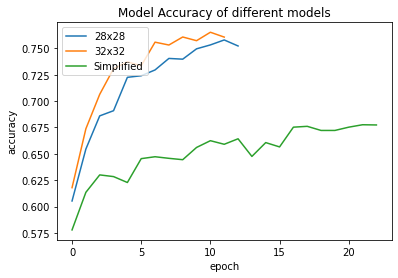

In [ ]:
plt.plot(history_25_28.history['val_accuracy'])
plt.plot(history_25_32.history['val_accuracy'])
plt.plot(history_simple_25.history['val_accuracy'])
plt.title('Model Accuracy of different models')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['28x28','32x32', 'Simplified'], loc='upper left')
plt.savefig('FinalEvaluation')
plt.show()

Plotting the loss of the test data while learning was conducted

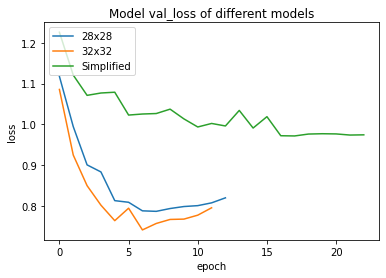

In [ ]:
plt.plot(history_25_28.history['val_loss'])
plt.plot(history_25_32.history['val_loss'])
plt.plot(history_simple_25.history['val_loss'])
plt.title('Model val_loss of different models')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['28x28','32x32', 'Simplified'], loc='upper left')
plt.savefig('FinalEvaluationLoss')
plt.show()

In this step we evaluate the models without using EarlyStop to see how the loss function changes but also how their accuracy increases when running the whole of the 25 epochs.

Also, we are using a callback to change the learning parameter when a plateau is detected.

In [ ]:
history_25_28_1 = baseline_model.fit(train_ds_28, epochs=25,verbose=1,
                    validation_data=test_ds_28, callbacks=[reduce_lr])

Epoch 1/25
1562/1562 [==============================] - 215s 135ms/step - loss: 1.4814 - accuracy: 0.4763 - val_loss: 1.1306 - val_accuracy: 0.5917 - lr: 0.0010
Epoch 2/25
1562/1562 [==============================] - 228s 144ms/step - loss: 1.0964 - accuracy: 0.6186 - val_loss: 0.9862 - val_accuracy: 0.6592 - lr: 0.0010
Epoch 3/25
1562/1562 [==============================] - 203s 128ms/step - loss: 0.9436 - accuracy: 0.6739 - val_loss: 0.8711 - val_accuracy: 0.6963 - lr: 0.0010
Epoch 4/25
1562/1562 [==============================] - 208s 131ms/step - loss: 0.8350 - accuracy: 0.7106 - val_loss: 0.7991 - val_accuracy: 0.7225 - lr: 0.0010
Epoch 5/25
1562/1562 [==============================] - 224s 142ms/step - loss: 0.7565 - accuracy: 0.7397 - val_loss: 0.8200 - val_accuracy: 0.7175 - lr: 0.0010
Epoch 6/25
1562/1562 [==============================] - 204s 129ms/step - loss: 0.6816 - accuracy: 0.7640 - val_loss: 0.8013 - val_accuracy: 0.7258 - lr: 0.0010
Epoch 7/25
1562/1562 [============

In [ ]:
history_25_32_1 = model_v1.fit(train_ds, epochs=25,verbose=1,
                    validation_data=test_ds, callbacks=[reduce_lr])

Epoch 1/25
1562/1562 [==============================] - 293s 185ms/step - loss: 1.4879 - accuracy: 0.4763 - val_loss: 1.1219 - val_accuracy: 0.6056 - lr: 0.0010
Epoch 2/25
1562/1562 [==============================] - 282s 179ms/step - loss: 1.0661 - accuracy: 0.6304 - val_loss: 0.9164 - val_accuracy: 0.6809 - lr: 0.0010
Epoch 3/25
1562/1562 [==============================] - 284s 180ms/step - loss: 0.8999 - accuracy: 0.6894 - val_loss: 0.8253 - val_accuracy: 0.7163 - lr: 0.0010
Epoch 4/25
1562/1562 [==============================] - 305s 193ms/step - loss: 0.7793 - accuracy: 0.7313 - val_loss: 0.7860 - val_accuracy: 0.7309 - lr: 0.0010
Epoch 5/25
1562/1562 [==============================] - 312s 198ms/step - loss: 0.6914 - accuracy: 0.7649 - val_loss: 0.7904 - val_accuracy: 0.7327 - lr: 0.0010
Epoch 6/25
1562/1562 [==============================] - 311s 198ms/step - loss: 0.6140 - accuracy: 0.7862 - val_loss: 0.7690 - val_accuracy: 0.7405 - lr: 0.0010
Epoch 7/25
1562/1562 [============

In [ ]:
history_simple_25_1 = simple_model.fit(train_ds_28, epochs=25,verbose=1, validation_data=test_ds_28, callbacks=[reduce_lr])

Epoch 1/25
1562/1562 [==============================] - 109s 68ms/step - loss: 1.6103 - accuracy: 0.4895 - val_loss: 1.2054 - val_accuracy: 0.5860 - lr: 0.0010
Epoch 2/25
1562/1562 [==============================] - 107s 67ms/step - loss: 1.1332 - accuracy: 0.6086 - val_loss: 1.1225 - val_accuracy: 0.6087 - lr: 0.0010
Epoch 3/25
1562/1562 [==============================] - 108s 68ms/step - loss: 1.0514 - accuracy: 0.6332 - val_loss: 1.0677 - val_accuracy: 0.6320 - lr: 0.0010
Epoch 4/25
1562/1562 [==============================] - 108s 67ms/step - loss: 0.9998 - accuracy: 0.6547 - val_loss: 1.0640 - val_accuracy: 0.6306 - lr: 0.0010
Epoch 5/25
1562/1562 [==============================] - 107s 67ms/step - loss: 0.9675 - accuracy: 0.6656 - val_loss: 1.0504 - val_accuracy: 0.6403 - lr: 0.0010
Epoch 6/25
1562/1562 [==============================] - 108s 67ms/step - loss: 0.9384 - accuracy: 0.6752 - val_loss: 1.0297 - val_accuracy: 0.6483 - lr: 0.0010
Epoch 7/25
1562/1562 [==================

Plotting the accuracy of the models.

32x32x2 input on the baseline model results in a better accuracy although it takes way longer to train the model. The simplified model is the worse performing model as expected.

All models seem to plateau after the 18 epoch mark.

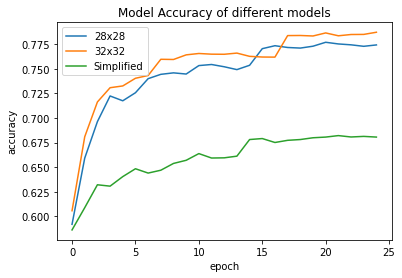

In [ ]:
plt.plot(history_25_28_1.history['val_accuracy'])
plt.plot(history_25_32_1.history['val_accuracy'])
plt.plot(history_simple_25_1.history['val_accuracy'])
plt.title('Model Accuracy of different models')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['28x28','32x32', 'Simplified'], loc='upper left')
plt.savefig('FinalEvaluationNoEarlyStop')
plt.show()

Plotting the loss function of all models being tested.

The simplified model can be seen performing the worst although suprisingly it seems to be slowly improving. The model with 32x32x3 input seems to be performing initially better but then it starts overfitting significantly and faster than the model with 28x28x3 input.

Both models follow the same trajectory when it comes to overfitting.

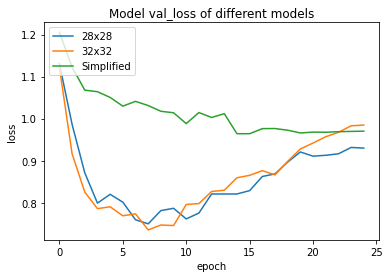

In [ ]:
plt.plot(history_25_28_1.history['val_loss'])
plt.plot(history_25_32_1.history['val_loss'])
plt.plot(history_simple_25_1.history['val_loss'])
plt.title('Model val_loss of different models')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['28x28','32x32', 'Simplified'], loc='upper left')
plt.savefig('FinalEvaluationLossNoEarlyStop')
plt.show()

Here we are testing a modification on the baseline network. The modification is the addition of extra convolutional and Dense filters. The idea behind this modification is to observe whether this model results in extracting more features from the images.

We can see that the new model has less parameters than the original architecture meaning that the increase depth may not result in a better performance.

In [ ]:
deep_model = Sequential()

deep_model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(5,5), padding='same', activation='relu', input_shape=(28, 28, 3)))
deep_model.add(tf.keras.layers.MaxPool2D(strides=2))
deep_model.add(tf.keras.layers.BatchNormalization())
deep_model.add(tf.keras.layers.Conv2D(filters=48, kernel_size=(5,5), padding='same', activation='relu'))
deep_model.add(tf.keras.layers.MaxPool2D(strides=2))
deep_model.add(tf.keras.layers.BatchNormalization())
deep_model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(5,5), padding='same', activation='relu'))
deep_model.add(tf.keras.layers.MaxPool2D(strides=2))
deep_model.add(tf.keras.layers.BatchNormalization())
deep_model.add(tf.keras.layers.Flatten())
deep_model.add(tf.keras.layers.Dropout(0.2))
deep_model.add(tf.keras.layers.Dense(256, activation='relu'))
deep_model.add(tf.keras.layers.Dropout(0.2))
deep_model.add(tf.keras.layers.Dense(128, activation='relu'))
deep_model.add(tf.keras.layers.Dropout(0.2))
deep_model.add(tf.keras.layers.Dense(84, activation='relu'))
deep_model.add(tf.keras.layers.Dropout(0.2))
deep_model.add(tf.keras.layers.Dense(10, activation='softmax'))

deep_model.compile(loss=sparse_categorical_crossentropy, optimizer=tf.optimizers.Adam(), metrics=['accuracy'])
deep_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 28, 28, 32)        2432      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 batch_normalization_12 (Bat  (None, 14, 14, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_13 (Conv2D)          (None, 14, 14, 48)        38448     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 7, 7, 48)         0         
 g2D)                                                            
                                                      

Training the network and keeping track of the accuracy and loss when using training and test data.

In [ ]:
history_deep = deep_model.fit(train_ds_28, epochs=25,verbose=1, validation_data=test_ds_28, callbacks=[reduce_lr])

Epoch 1/25
1562/1562 [==============================] - 295s 187ms/step - loss: 1.5536 - accuracy: 0.4440 - val_loss: 1.2390 - val_accuracy: 0.5634 - lr: 0.0010
Epoch 2/25
1562/1562 [==============================] - 294s 186ms/step - loss: 1.1698 - accuracy: 0.5931 - val_loss: 0.9824 - val_accuracy: 0.6585 - lr: 0.0010
Epoch 3/25
1562/1562 [==============================] - 293s 186ms/step - loss: 0.9999 - accuracy: 0.6586 - val_loss: 0.8993 - val_accuracy: 0.6901 - lr: 0.0010
Epoch 4/25
1562/1562 [==============================] - 292s 185ms/step - loss: 0.8808 - accuracy: 0.7012 - val_loss: 0.8340 - val_accuracy: 0.7142 - lr: 0.0010
Epoch 5/25
1562/1562 [==============================] - 294s 186ms/step - loss: 0.8044 - accuracy: 0.7283 - val_loss: 0.8072 - val_accuracy: 0.7271 - lr: 0.0010
Epoch 6/25
1562/1562 [==============================] - 293s 186ms/step - loss: 0.7459 - accuracy: 0.7480 - val_loss: 0.7770 - val_accuracy: 0.7346 - lr: 0.0010
Epoch 7/25
1562/1562 [============

We can see a significant improvement when it comes to the accuracy using testing data. This is important as it indicates that the extra depth result in better accuracy somethingh that we were concerned about due to the less number of parameters that the model has.

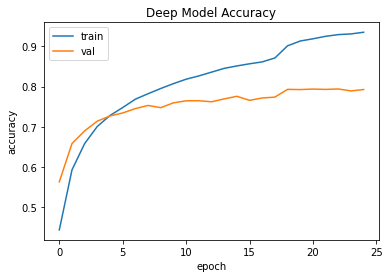

In [ ]:
plt.plot(history_deep.history['accuracy'])
plt.plot(history_deep.history['val_accuracy'])
plt.title('Deep Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

The model seems to be not performing as well as the other models when it comes to the loss function. The loss is actually higher than the other 2 models we have previously seen, baseline 32x32x3 and baseline 28x28x3. This may be due to the extra layers of the network that do not allow for the loss to propagate correctly through the network. Thus meaning that the model is not learning and performing well.

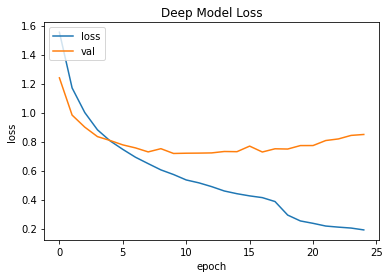

In [ ]:
plt.plot(history_deep.history['loss'])
plt.plot(history_deep.history['val_loss'])
plt.title('Deep Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val'], loc='upper left')
plt.show()